# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

In [125]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [99]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [100]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

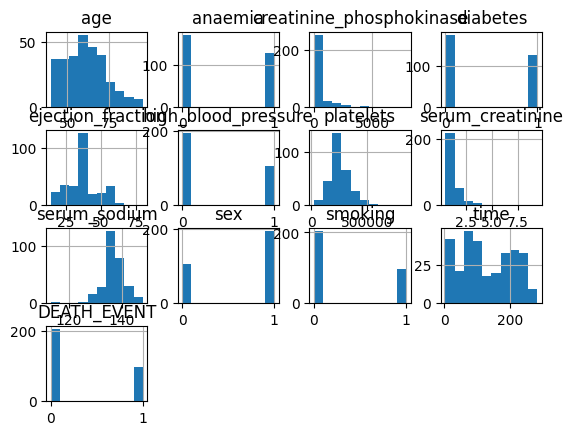

In [101]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist()

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [102]:
# Split into 80/20. 80% for cross validated training, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [103]:
# Separate input features from targets in all partitions

trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test.DEATH_EVENT

In [104]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [105]:
# A custom function for returning the results for all metrics based on the best f1 score on test data
def show_cv_results(cv_results):
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=True)
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [106]:
# Define the metrics that we wan't to use. The names of available scorers can be accessed through
# get_scorer_names. The actual scorer objects are found using get_scorer
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [107]:
# Train a decision tree using grid search

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring=metrics, refit='f1',return_train_score=True)

dt_grid.fit(trainval_features, trainval_targets)

dt_cv_results = pd.DataFrame(dt_grid.cv_results_)
dt_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001665,0.001138,0.005451,0.001617,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.854167,0.791667,0.854167,0.875000,0.744681,0.823936,0.048493,1,0.827225,0.842932,0.827225,0.821990,0.854167,0.834708,0.012000,0.833333,0.727273,1.000000,0.857143,0.636364,0.810823,0.123172,1,0.853659,0.833333,0.818182,0.800000,0.854167,0.831868,0.020867,0.666667,0.533333,0.5625,0.750,0.466667,0.595833,0.100485,35,0.564516,0.645161,0.590164,0.590164,0.661290,0.610259,0.036667,0.740741,0.615385,0.720000,0.800000,0.538462,0.682917,0.093654,4,0.679612,0.727273,0.685714,0.679245,0.745455,0.703460,0.027570,0.803030,0.721212,0.781250,0.843750,0.670833,0.764015,0.061142,7,0.759002,0.791573,0.764313,0.760467,0.803722,0.775815,0.018318
1,0.001168,0.000055,0.004583,0.000054,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.812500,0.791667,0.791667,0.791667,0.744681,0.786436,0.022383,11,0.832461,0.842932,0.827225,0.842932,0.854167,0.839943,0.009359,0.666667,0.727273,1.000000,0.666667,0.636364,0.739394,0.133609,4,0.727273,0.833333,0.888889,0.738462,0.854167,0.808425,0.064293,0.800000,0.533333,0.3750,0.750,0.466667,0.585000,0.163843,38,0.774194,0.645161,0.524590,0.786885,0.661290,0.678424,0.095917,0.727273,0.615385,0.545455,0.705882,0.538462,0.626491,0.078612,32,0.750000,0.727273,0.659794,0.761905,0.745455,0.728885,0.036296,0.845455,0.815152,0.886719,0.847656,0.771875,0.833371,0.038236,1,0.854589,0.878657,0.850883,0.858134,0.891191,0.866691,0.015576
2,0.001236,0.000019,0.004620,0.000117,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.770833,0.791667,0.791667,0.812500,0.765957,0.786525,0.016714,9,0.869110,0.863874,0.869110,0.874346,0.875000,0.870288,0.004064,0.625000,0.631579,0.800000,0.705882,0.666667,0.685826,0.063949,11,0.793651,0.757143,0.846154,0.849057,0.865385,0.822278,0.040515,0.666667,0.800000,0.5000,0.750,0.533333,0.650000,0.117379,8,0.806452,0.854839,0.721311,0.737705,0.725806,0.769223,0.052707,0.645161,0.705882,0.615385,0.727273,0.592593,0.657259,0.051668,9,0.800000,0.803030,0.778761,0.789474,0.789474,0.792148,0.008644,0.790909,0.821212,0.863281,0.809570,0.831250,0.823245,0.024099,3,0.905601,0.922918,0.903405,0.917907,0.919913,0.913949,0.007906
3,0.001315,0.000023,0.004704,0.000230,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.791667,0.833333,0.854167,0.812500,0.744681,0.807270,0.037595,5,0.895288,0.905759,0.905759,0.890052,0.906250,0.900622,0.006703,0.666667,0.733333,0.909091,0.769231,0.588235,0.733311,0.107403,5,0.818182,0.833333,0.921569,0.

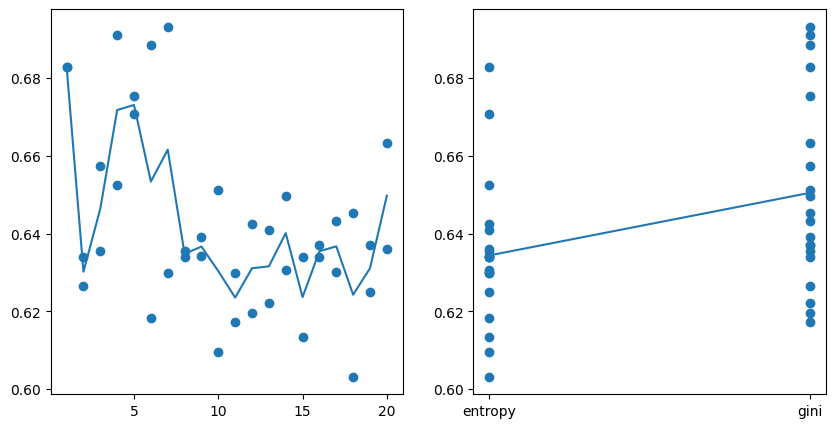

In [108]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
dt_param_scores = dt_cv_results[['param_max_depth', 'param_criterion', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
dt_max_depth = dt_param_scores.pivot_table(index='param_criterion', columns='param_max_depth', values='mean_test_f1')
dt_max_depth_means = dt_max_depth.mean(axis=0)

# A frame to find the average performance of each criteria value
dt_criterion = dt_param_scores.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_f1')
dt_criterion_means = dt_criterion.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(dt_max_depth_means.index, dt_max_depth_means)
ax[0].scatter(dt_cv_results['param_max_depth'], dt_cv_results['mean_test_f1'])
ax[1].plot(dt_criterion_means.index, dt_criterion_means)
ax[1].scatter(dt_cv_results['param_criterion'], dt_cv_results['mean_test_f1'])
plt.show()


In [109]:
show_cv_results(dt_cv_results)

mean_train_f1           0.979191
mean_train_precision    0.975092
mean_train_recall       0.983765
mean_train_accuracy     0.986393
mean_train_roc_auc      0.998409
mean_test_f1            0.693154
mean_test_precision     0.715535
mean_test_recall        0.676667
mean_test_accuracy      0.807624
mean_test_roc_auc       0.765830
Name: 6, dtype: float64

In [110]:
evaluate(dt_grid)

Training Accuracy: 0.9748953974895398
Training Precision: 0.9863013698630136
Training Recall: 0.935064935064935
Training F1: 0.9600000000000001
Training ROC AUC: 0.9973144139810807
Test Accuracy: 0.7666666666666667
Test Precision: 0.6470588235294118
Test Recall: 0.5789473684210527
Test F1: 0.6111111111111113
Test ROC AUC: 0.7991014120667522



In [111]:
# Calculate the confusion matrix for the best decision tree model.

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[35,  6],
       [ 8, 11]])

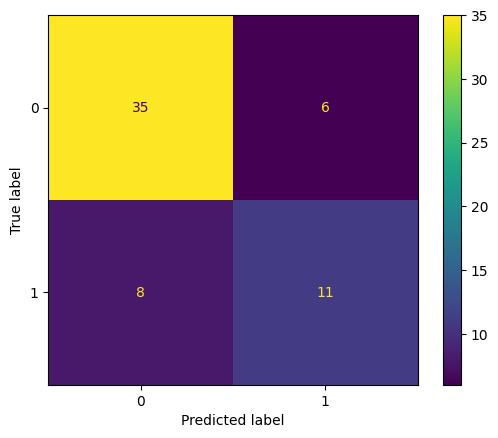

In [112]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

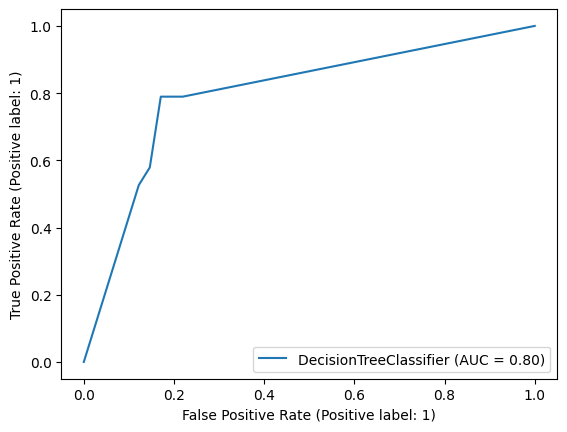

In [113]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid.best_estimator_, test_features, test_targets)

The ROC curve show very good performance for all sensitivities. This is also shown by the AUC of 0.84

In [114]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001185,0.000134,0.004884,0.000314,0.0,{'var_smoothing': 1e-10},0.833333,0.791667,0.812500,0.750000,0.744681,0.786436,0.034575,3,0.774869,0.827225,0.769634,0.801047,0.791667,0.792888,0.020555,0.888889,0.727273,0.888889,0.700000,0.714286,0.783867,0.086183,2,0.743590,0.822222,0.757576,0.810811,0.805556,0.787951,0.031297,0.533333,0.533333,0.5000,0.4375,0.333333,0.467500,0.075664,3,0.467742,0.596774,0.409836,0.491803,0.467742,0.486779,0.061269,0.666667,0.615385,0.640000,0.538462,0.454545,0.583012,0.077178,3,0.574257,0.691589,0.531915,0.612245,0.591837,0.600369,0.052731,0.886869,0.878788,0.824219,0.847656,0.818750,0.851256,0.027665,1,0.861090,0.863966,0.871501,0.881211,0.876923,0.870938,0.007580
1,0.001091,0.000025,0.004723,0.000125,0.0,{'var_smoothing': 1e-09},0.854167,0.854167,0.750000,0.833333,0.765957,0.811525,0.044663,1,0.795812,0.837696,0.801047,0.806283,0.838542,0.815876,0.018463,0.900000,0.833333,0.750000,0.785714,0.700000,0.793810,0.068737,1,0.767442,0.829787,0.810811,0.815789,0.860465,0.816859,0.030161,0.600000,0.666667,0.3750,0.6875,0.466667,0.559167,0.120139,1,0.532258,0.629032,0.491803,0.508197,0.596774,0.551613,0.052669,0.720000,0.740741,0.500000,0.733333,0.560000,0.650815,0.100673,1,0.628571,0.715596,0.612245,0.626263,0.704762,0.657487,0.043519,0.842424,0.878788,0.824219,0.853516,0.804167,0.840623,0.025394,2,0.852463,0.854839,0.854729,0.868852,0.870471,0.860271,0.007731
2,0.001081,0.000020,0.004654,0.000097,0.0,{'var_smoothing': 1e-08},0.854167,0.812500,0.708333,0.833333,0.765957,0.794858,0.052213,2,0.806283,0.842932,0.764398,0.816754,0.817708,0.809615,0.025621,0.900000,0.875000,0.625000,0.785714,0.700000,0.777143,0.103771,3,0.804878,0.833333,0.766667,0.842105,0.829268,0.815250,0.027249,0.600000,0.466667,0.3125,0.6875,0.466667,0.506667,0.128306,2,0.532258,0.645161,0.377049,0.524590,0.548387,0.525489,0.085938,0.720000,0.608696,0.416667,0.733333,0.560000,0.607739,0.115901,2,0.640777,0.727273,0.505495,0.646465,0.660194,0.636041,0.072222,0.848485,0.864646,0.789062,0.861328,0.779167,0.828538,0.036804,3,0.832208,0.839835,0.840101,0.849306,0.858809,0.844052,0.009155
3,0.001077,0.000008,0.004654,0.000085,0.0,{'var_smoothing': 1e-07},0.770833,0.770833,0.645833,0.812500,0.744681,0.748936,0.055942,4,0.774869,0.821990,0.738220,0.774869,0.786458,0.779281,0.026835,0.833333,0.700000,0.428571,0.888889,0.666667,0.703492,0.160113,4,0.787879,0.833333,0.720000,0.750000,0.838710,0.785984,0.046205,0.333333,0.466667,0.1875,0.5000,0.400000,0.377500,0.

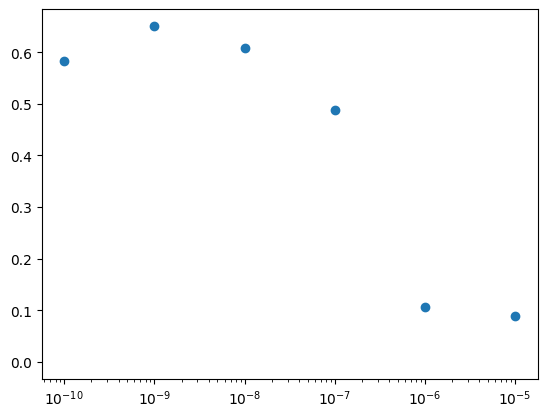

In [115]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

In [116]:
show_cv_results(nb_cv_results)

mean_train_f1           0.657487
mean_train_precision    0.816859
mean_train_recall       0.551613
mean_train_accuracy     0.815876
mean_train_roc_auc      0.860271
mean_test_f1            0.650815
mean_test_precision     0.793810
mean_test_recall        0.559167
mean_test_accuracy      0.811525
mean_test_roc_auc       0.840623
Name: 1, dtype: float64

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

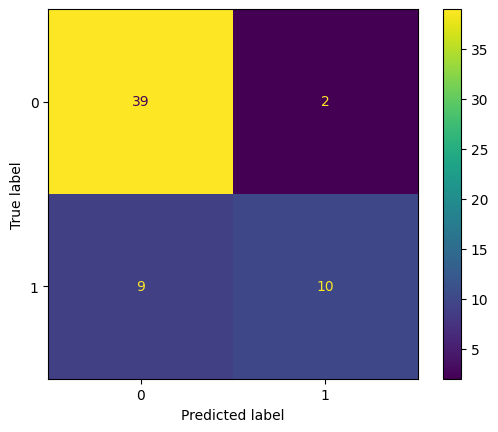

In [117]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

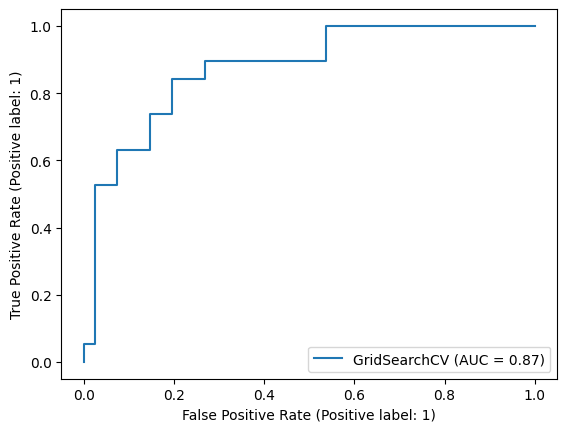

In [118]:
RocCurveDisplay.from_estimator(nb_grid, test_features, test_targets)

In [ ]:
class CombinedNB(BaseEstimator, ClassifierMixin):
    __init__(self, gaussion_features, bernoulli_features):
        self.gaussian = GaussianNB()
        self.bernoulli = BernoulliNB()

    def fit(self, X, y):
        self.gaussian.fit(X[self.gaussian_features], y)
        self.bernoulli.fit(X[self.bernoulli_features], y)
       
    def predict(self, X):

    def predict_proba(self, X):
        self


In [119]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.005113,0.000057,0.005408,0.000318,0.5,balanced,rbf,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.416667,0.625000,0.708333,0.645833,0.659574,0.611082,0.101003,17,0.434555,0.680628,0.670157,0.617801,0.666667,0.613962,0.092284,0.290323,0.285714,1.000000,0.444444,0.428571,0.489811,0.263648,1,0.333333,0.526316,0.375000,0.333333,0.461538,0.405904,0.076266,0.600000,0.133333,0.1250,0.2500,0.200000,0.261667,0.175246,8,0.741935,0.161290,0.049180,0.196721,0.193548,0.268535,0.242696,0.391304,0.181818,0.222222,0.320000,0.272727,0.277614,0.073472,8,0.460000,0.246914,0.086957,0.247423,0.272727,0.262804,0.118656,0.505051,0.501010,0.562500,0.494141,0.527083,0.517957,0.024853,16,0.534384,0.564766,0.547415,0.530643,0.534491,0.542340,0.012573
1,0.007363,0.002670,0.005175,0.000091,0.5,balanced,poly,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.291667,0.312500,0.333333,0.375000,0.340426,0.330585,0.027996,21,0.350785,0.335079,0.329843,0.335079,0.338542,0.337865,0.007032,0.297872,0.312500,0.333333,0.340909,0.318182,0.320559,0.015249,6,0.329670,0.328042,0.322751,0.320652,0.324324,0.325088,0.003330,0.933333,1.000000,1.0000,0.9375,0.933333,0.960833,0.032016,1,0.967742,1.000000,1.000000,0.967213,0.967742,0.980539,0.015891,0.451613,0.476190,0.500000,0.500000,0.474576,0.480476,0.018158,1,0.491803,0.494024,0.488000,0.481633,0.485830,0.488258,0.004374,0.505051,0.523232,0.595703,0.501953,0.535417,0.532271,0.033986,9,0.534384,0.536634,0.523329,0.535939,0.531141,0.532286,0.004862
2,0.006638,0.000079,0.005453,0.000213,0.5,balanced,sigmoid,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.708333,0.666667,0.666667,0.666667,0.680851,0.677837,0.016208,1,0.643979,0.680628,0.680628,0.680628,0.677083,0.672589,0.014371,0.600000,0.333333,0.000000,0.000000,0.000000,0.186667,0.243676,12,0.375000,0.600000,0.000000,0.000000,0.000000,0.195000,0.249199,0.200000,0.066667,0.0000,0.0000,0.000000,0.053333,0.077746,12,0.145161,0.048387,0.000000,0.000000,0.000000,0.038710,0.056429,0.300000,0.111111,0.000000,0.000000,0.000000,0.082222,0.117084,12,0.209302,0.089552,0.000000,0.000000,0.000000,0.059771,0.082419,0.589899,0.541414,0.605469,0.564453,0.512500,0.562747,0.033302,2,0.491748,0.520880,0.551072,0.554981,0.539826,0.531701,0.023223
3,0.003858,0.000214,0.005028,0.000037,0.5,None,rbf,"{'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,0.

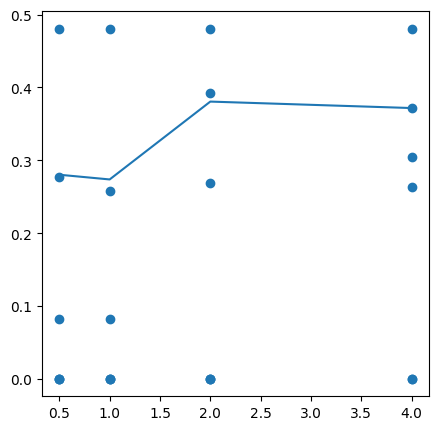

In [120]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned three parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
svc_param_scores = svc_cv_results[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average C performance 
# accross the other parameter values
svc_c = svc_param_scores.pivot_table(index=['param_class_weight','param_kernel'], columns='param_C', values='mean_test_f1')
svc_c_means = svc_c.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(svc_c_means.index, svc_c_means)
ax.scatter(svc_cv_results['param_C'], svc_cv_results['mean_test_f1'])
plt.show()


In [121]:
show_cv_results(svc_cv_results)

mean_train_f1           0.488258
mean_train_precision    0.325088
mean_train_recall       0.980539
mean_train_accuracy     0.337865
mean_train_roc_auc      0.532286
mean_test_f1            0.480476
mean_test_precision     0.320559
mean_test_recall        0.960833
mean_test_accuracy      0.330585
mean_test_roc_auc       0.532271
Name: 1, dtype: float64

In [122]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

evaluate(dt_grid.best_estimator_)
evaluate(nb_grid.best_estimator_)
evaluate(svc_grid.best_estimator_)

Training Accuracy: 0.9748953974895398
Training Precision: 0.9863013698630136
Training Recall: 0.935064935064935
Training F1: 0.9600000000000001
Training ROC AUC: 0.9973144139810807
Test Accuracy: 0.7666666666666667
Test Precision: 0.6470588235294118
Test Recall: 0.5789473684210527
Test F1: 0.6111111111111113
Test ROC AUC: 0.7991014120667522

Training Accuracy: 0.8158995815899581
Training Precision: 0.8
Training Recall: 0.5714285714285714
Training F1: 0.6666666666666666
Training ROC AUC: 0.86002886002886
Test Accuracy: 0.8166666666666667
Test Precision: 0.8333333333333334
Test Recall: 0.5263157894736842
Test F1: 0.6451612903225806
Test ROC AUC: 0.8741976893453145

Training Accuracy: 0.6736401673640168
Training Precision: 0.0
Training Recall: 0.0
Training F1: 0.0
Training ROC AUC: 0.4683341350008017
Test Accuracy: 0.6833333333333333
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC AUC: 0.4865211810012837



/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.